## 特徴量選択
- 特徴量を大量に作ったあとは重要な特徴量を選択して減らす必要がある
    - 特徴量が多ければ多い方がいいというわけではない（次元の呪い）
- 特徴量選択の手法
    -　greedy feature selection
    - recursive feature elimination
    - モデルの特徴量の重要度で判断する
        - 線形回帰等のパラメトリックモデルの係数を見る（t検定量等）
        - 決定木などの特徴量重要度みる
    - L1正則化項による特徴量選択

## greedy feature selection
- greedyに特徴量の追加と評価を繰り返す
    - 1, それぞれの特徴量単体でモデルを評価し、最高精度の特徴量を選択する
    - 2, 残りの特料料を1つ追加しモデルを評価し、残りの特徴量全てに実施し最高精度の特徴量を選択する
    - 3, 2、を最高精度を更新しなくなるまで繰り返す
- 計算量が高くなりやすいので注意
- 高精度なモデルが必要な際に有効

## recursive feature elimination

- greedy feature elimintion 　の逆で、全ての特徴量でモデルを構築してから特徴量を1つずつ減らしていく
    - 1,全ての特徴量で燃えるを学習する
    - 2,モデルへの影響が最も低い特徴量を落とし、残りの特徴量でモデルを学習する
    - 3,2を指定した特徴量の数になるまで実施する
  
- モデルへの影響
    - 線形回帰の係数（p値）や決定木の重要度を利用する
    - 重要度などの指標を持ったモデルを使用する

- あらかじめ最終的に残す特徴量の数を決めておく

## モデルの係数や重要度で特徴量選択
- モデルが出力した特徴量の重要度を使って閾値を定めて選択する
- モデルによっては特徴量の重要度を確認できる
    - 線形回帰やロジスティック回帰の係数　ー> 重要度を表す！θの部分のこと。係数のt検定によりp値を求める。統計量には統計検定量tを使用する
    - 決定木の重要度
- 異なるモデルで重要度を確認することも可能
    - 例：ロジスティック回帰で係数をもとに特徴量選択をし決定木で予測モデル構築
- 気軽に利用できる
- 閾値を決定するのが難しい
- 予算内で将来取得する特徴量をきめたい場合などには有効
- 精度が極端に落ちる可能性もあるので注意が必要

##  正則化項（L1ノルム：ラッソ）による特徴量選択
- L1ノルムの正則化項を使用
- λを大きくするにつれ各特徴量の係数の絶対値が小さくなり、やがて0になる
- 特徴量同士のスケールが影響するので事前に特徴量スケーリングが必要
- 学習後、一部（or全て）ぼ特徴量の係数が0になることを期待する
    - Lassoは特徴量選択を自動で行うアルゴリズム

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Greedy feature selection

In [2]:
df = pd.read_csv('penguins_size.csv')
df.loc[df[df['sex']=='.'].index, 'sex']=np.nan

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# 全てのレコードは三つ以上の値を持っていなければならない。持っていなければdropする

df.dropna(thresh=3, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 21.4+ KB


In [6]:
# X, y 作成
X = df.drop('species', axis=1)
y = df['species']

# カテゴリカルの欠損値代入にはNaNを代入し新たなカテゴリとして扱う
imputer = SimpleImputer(strategy='constant', fill_value='NaN')
imputer.set_output(transform='pandas')

# sexカラムにのみ実行するように設定
# X全体にfit_transformをすると，全てのカラムのDtypeがobjectになってしまい，後続のダミー変数作成の際に全カラムに対してOHEしてしまうため，
# ここではsexカラムを指定して，sexカラムにのみ実施する
X['sex'] = imputer.fit_transform(X[['sex']])

# OHE 従来のGetDummiesにはfit, transformのメソッドがない為、pipelineに含める為に自作のものを作る必要がある
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)


# 特徴量エンジニアリング
# 多項式特徴量
poly = PolynomialFeatures(degree=2, include_bias=False)
X[['culmen_length_mm', 'culmen_depth_mm', 'culmen_length_mm^2', 'culmen_length_mm * culmen_depth_mm', 'culmen_depth_mm^2']] = poly.fit_transform(X[['culmen_length_mm', 'culmen_depth_mm']])
# 四則演算
X['culmen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['culmen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']


# Pipeline
pipeline = Pipeline([('dummy', GetDummies()),
          ('scaler', StandardScaler()),
          ('model', LogisticRegression())])

# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)

In [7]:
class GreedyFeatureSelection():
    
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        self.scores = [0]
    
    def select_feature(self, X, y):
        
        all_features = X.columns
        
        while True:
            print('greedy selection started')
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    continue
                print(f'{feature} started')
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                print(f'{features} score: {score}')
                if score > best_score:
                    print(f'best score updated {best_score} -> {score}')
                    best_score = score
                    candidate_feature = feature
            
            if candidate_feature is not None:
                print(f'========{candidate_feature} is selected=============')
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                break


In [8]:
# Greedy feature selection
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)
# スコアの結果と選択された特徴量を確認
print(gfs.scores)
print(gfs.selected_features)

greedy selection started
island started
['island'] score: 0.7076023391812866
best score updated 0 -> 0.7076023391812866
culmen_length_mm started
['culmen_length_mm'] score: 0.7514619883040936
best score updated 0.7076023391812866 -> 0.7514619883040936
culmen_depth_mm started
['culmen_depth_mm'] score: 0.7573099415204679
best score updated 0.7514619883040936 -> 0.7573099415204679
flipper_length_mm started
['flipper_length_mm'] score: 0.7982456140350876
best score updated 0.7573099415204679 -> 0.7982456140350876
body_mass_g started
['body_mass_g'] score: 0.7309941520467835
sex started
['sex'] score: 0.39181286549707606
culmen_length_mm^2 started
['culmen_length_mm^2'] score: 0.7543859649122808
culmen_length_mm * culmen_depth_mm started
['culmen_length_mm * culmen_depth_mm'] score: 0.5350877192982456
culmen_depth_mm^2 started
['culmen_depth_mm^2'] score: 0.7573099415204679
culmen_diff started
['culmen_diff'] score: 0.8187134502923977
best score updated 0.7982456140350876 -> 0.818713450292

# recursive feature elimination(REF)

In [9]:
# estimatorは決定木を使うことが多い
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
X

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,culmen_length_mm^2,culmen_length_mm * culmen_depth_mm,culmen_depth_mm^2,culmen_diff,culmen_ratio,island_Dream,island_Torgersen,sex_MALE,sex_NaN
0,39.1,18.7,181.0,3750.0,1528.81,731.17,349.69,20.4,2.090909,0,1,1,0
1,39.5,17.4,186.0,3800.0,1560.25,687.30,302.76,22.1,2.270115,0,1,0,0
2,40.3,18.0,195.0,3250.0,1624.09,725.40,324.00,22.3,2.238889,0,1,0,0
4,36.7,19.3,193.0,3450.0,1346.89,708.31,372.49,17.4,1.901554,0,1,0,0
5,39.3,20.6,190.0,3650.0,1544.49,809.58,424.36,18.7,1.907767,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,2227.84,646.64,187.69,33.5,3.445255,0,0,0,0
340,46.8,14.3,215.0,4850.0,2190.24,669.24,204.49,32.5,3.272727,0,0,0,0
341,50.4,15.7,222.0,5750.0,2540.16,791.28,246.49,34.7,3.210191,0,0,1,0
342,45.2,14.8,212.0,5200.0,2043.04,668.96,219.04,30.4,3.054054,0,0,0,0


In [10]:
rfe.fit(X, y)
rfe.transform(X)

array([[20.4       ,  2.09090909,  0.        ,  1.        ,  1.        ,
         0.        ],
       [22.1       ,  2.27011494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [22.3       ,  2.23888889,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ,  0.        ,  1.        ,
         0.        ],
       [30.4       ,  3.05405405,  0.        ,  0.        ,  0.        ,
         0.        ],
       [33.8       ,  3.09937888,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [11]:
# 特徴量の重要度ランキング
rfe.ranking_

array([8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1])

In [12]:
# 選択された特徴量のリストを取得
# rfe.feature_names_in_[rfe.ranking_==1]

# support_で特徴量の選択結果のマスクを取得
rfe.feature_names_in_[rfe.support_]


array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [13]:
# Pipelineに組み込む
pipeline = Pipeline([('rfe', rfe), ('scaler', StandardScaler()), ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)


[1.         1.         0.99122807]


In [14]:
# RFECV
rfecv = RFECV(DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)


array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [15]:
rfecv.feature_names_in_[rfecv.support_]


array(['culmen_diff', 'culmen_ratio', 'island_Dream'], dtype=object)

<ErrorbarContainer object of 3 artists>

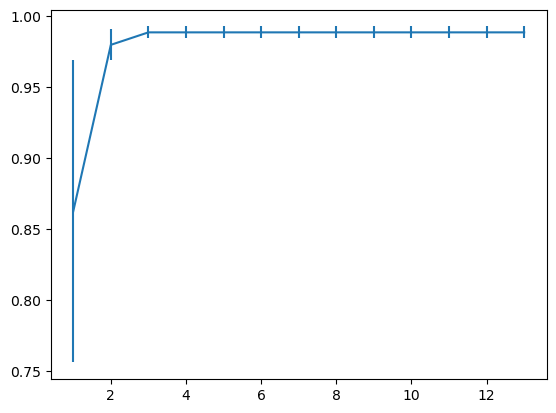

In [16]:
# 特徴量の数と精度の推移を描画
import matplotlib.pyplot as plt
plt.errorbar(range(1, 1+len(rfecv.cv_results_['mean_test_score'])),
            rfecv.cv_results_['mean_test_score'],
            yerr=rfecv.cv_results_['std_test_score'])

## モデルの係数や重要度で特徴量選択

In [17]:
# モデルの係数や重要度で特徴量選択
# RandomForestを使って特徴量の重要度が低い特徴量を落とす
sfm = SelectFromModel(RandomForestClassifier(random_state=0))
X_selected = sfm.fit_transform(X, y)
X_selected


array([[ 39.1       ,  18.7       , 181.        , ..., 349.69      ,
         20.4       ,   2.09090909],
       [ 39.5       ,  17.4       , 186.        , ..., 302.76      ,
         22.1       ,   2.27011494],
       [ 40.3       ,  18.        , 195.        , ..., 324.        ,
         22.3       ,   2.23888889],
       ...,
       [ 50.4       ,  15.7       , 222.        , ..., 246.49      ,
         34.7       ,   3.21019108],
       [ 45.2       ,  14.8       , 212.        , ..., 219.04      ,
         30.4       ,   3.05405405],
       [ 49.9       ,  16.1       , 213.        , ..., 259.21      ,
         33.8       ,   3.09937888]])

In [18]:
# .estimator_で特徴量選択に使用したモデルにアクセス
sfm.estimator_.feature_importances_


array([0.08924232, 0.07961904, 0.09933245, 0.0525517 , 0.08072858,
       0.01467092, 0.10925035, 0.14543881, 0.24562145, 0.07424349,
       0.00630753, 0.00299336, 0.        ])

In [19]:
# 選択された特徴量のリストを取得
sfm.feature_names_in_[sfm.get_support()]


array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'culmen_length_mm^2', 'culmen_depth_mm^2', 'culmen_diff',
       'culmen_ratio'], dtype=object)

## 正則化項による特徴選択

In [20]:
# estimtatorにl1正則を使用するモデルを入れると，l1正則を使って特徴量選択が可能
sfm = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('feature selection', sfm)])
pipeline.set_output(transform='pandas')
pipeline.fit_transform(X, y)


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,culmen_length_mm * culmen_depth_mm,culmen_depth_mm^2,culmen_diff,culmen_ratio,island_Dream,island_Torgersen,sex_MALE
0,-0.884499,0.785449,-1.418347,-0.564142,-0.170197,0.768371,-1.024588,-1.036429,-0.754193,2.388699,1.017700
1,-0.811126,0.126188,-1.062250,-0.501703,-0.550838,0.070068,-0.751183,-0.675598,-0.754193,2.388699,-0.982607
2,-0.664380,0.430462,-0.421277,-1.188532,-0.220261,0.386112,-0.719018,-0.738471,-0.754193,2.388699,-0.982607
4,-1.324737,1.089724,-0.563715,-0.938776,-0.368543,1.107627,-1.507068,-1.417695,-0.754193,2.388699,-0.982607
5,-0.847812,1.748985,-0.777373,-0.689020,0.510134,1.879435,-1.297994,-1.405186,-0.754193,2.388699,1.017700
...,...,...,...,...,...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,-0.903628,-1.642135,1.082241,1.690550,-0.754193,-0.418638,-0.982607
340,0.527932,-1.445897,1.003109,0.809516,-0.707537,-1.392157,0.921415,1.343164,-0.754193,-0.418638,-0.982607
341,1.188289,-0.735923,1.501644,1.933419,0.351353,-0.767211,1.275233,1.217248,-0.754193,-0.418638,1.017700
342,0.234440,-1.192335,0.789451,1.246590,-0.709967,-1.175658,0.583679,0.902865,-0.754193,-0.418638,-0.982607


In [21]:
# 使用したロジスティック回帰の係数(3クラス分)を確認
sfm.estimator_.coef_


array([[ 0.        ,  0.        , -0.17557748,  0.        ,  0.        ,
         0.        ,  0.02436242, -6.84438191, -0.17915033, -0.35603447,
         0.88718039,  1.1762001 ,  0.        ],
       [ 4.21350429,  0.        ,  0.        , -2.37103665,  0.        ,
         0.14716769,  0.        ,  0.        ,  0.        ,  2.66116048,
         0.        , -0.75559069,  0.        ],
       [ 0.        , -2.76946455,  1.6940958 ,  1.82209483,  0.        ,
         0.        ,  0.        ,  0.        ,  0.50806932, -0.24132139,
         0.        ,  0.        ,  0.        ]])

In [22]:
# 選択された特徴量のリスト
sfm.feature_names_in_[sfm.get_support()]


array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'culmen_length_mm * culmen_depth_mm',
       'culmen_depth_mm^2', 'culmen_diff', 'culmen_ratio', 'island_Dream',
       'island_Torgersen', 'sex_MALE'], dtype=object)